# Transformations notebook

In this notebook i'm performing some transformations on the **Rapporti_di_lavoro_attivati.csv** dataset in order to convert all the categorical features into numerical features, which are more suitable for the predicting stage.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import missing_values_table
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score


In [4]:
activated_labours = pd.read_csv('./activated_labours_cleaned.csv')
activated_labours.head()

,Unnamed: 0,DATA,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
0,0,1973-02-01,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1,1,1974-11-06,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
2,2,1976-01-10,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
3,3,1978-01-05,M,25,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA
4,4,1978-10-07,M,26,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA


## Transformations

In [5]:
activated_transformed = pd.DataFrame()

Converting **GENERE** column to dummies

In [6]:
df_col = activated_labours['GENERE'].values.reshape(-1,1)
df_col

array([['F'],
       ['F'],
       ['F'],
       ...,
       ['M'],
       ['F'],
       ['M']], dtype=object)

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc_gen = OneHotEncoder()
X = enc_gen.fit_transform(df_col).toarray()
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [8]:
dfOneHot = pd.DataFrame(X, columns = ['GENERE_F', 'GENERE_M'])
activated_transformed = pd.concat([activated_transformed, dfOneHot], axis=1)
activated_transformed.head()

,GENERE_F,GENERE_M
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


Transforming **TITOLO STUDIO** with manually defined transformation(in order to maintain the ordinal information of data).

[ISTAT document](https://www.istat.it/it/files/2011/01/Classificazione-titoli-studio-28_ott_2005-nota_metodologica.pdf)

In [9]:
activated_labours.TITOLOSTUDIO.unique()

array(['NESSUN TITOLO DI STUDIO', 'LICENZA MEDIA', 'LICENZA ELEMENTARE',
       "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LAUREA - Vecchio o nuovo ordinamento',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI DOTTORE DI RICERCA',
       'TITOLO DI STUDIO POST-LAUREA'], dtype=object)

In [10]:
studylevel_mapper = {'NESSUN TITOLO DI STUDIO': 0,
          'LICENZA ELEMENTARE': 1,
          'LICENZA MEDIA': 2,
          'TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L\'ACCESSO ALL\'UNIVERSITÀ ()': 3,
          'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 4,
          'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 5,
          'DIPLOMA UNIVERSITARIO': 6,
          'LAUREA - Vecchio o nuovo ordinamento': 7,
          'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 8,
          'DIPLOMA DI SPECIALIZZAZIONE': 9,
          'TITOLO DI DOTTORE DI RICERCA': 10,
          'TITOLO DI STUDIO POST-LAUREA': 11,}
activated_transformed['TITOLOSTUDIO'] = activated_labours['TITOLOSTUDIO'].replace(studylevel_mapper)
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO
0,1.0,0.0,0
1,1.0,0.0,0
2,1.0,0.0,0
3,0.0,1.0,0
4,0.0,1.0,0


In [11]:
activated_transformed.TITOLOSTUDIO.unique()

array([ 0,  2,  1,  4,  7,  3,  8,  5,  6,  9, 10, 11])

Transforming **MODALITÀ LAVORO** using LabelEncoder

In [12]:
activated_labours.MODALITALAVORO.unique()

array(['TEMPO PARZIALE ORIZZONTALE', 'TEMPO PIENO', 'NON DEFINITO',
       'TEMPO PARZIALE MISTO', 'TEMPO PARZIALE VERTICALE'], dtype=object)

In [13]:
le_workmode = LabelEncoder()
transformed_col = le_workmode.fit_transform(activated_labours.MODALITALAVORO)
transformed_col

array([2, 2, 2, ..., 0, 2, 4])

In [14]:
activated_transformed['MODALITALAVORO'] = transformed_col
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO
0,1.0,0.0,0,2
1,1.0,0.0,0,2
2,1.0,0.0,0,2
3,0.0,1.0,0,4
4,0.0,1.0,0,4


In [15]:
activated_transformed.MODALITALAVORO.unique()

array([2, 4, 0, 1, 3])

Transforming **PROVINCIA IMPRESA** and **NAZIONALITÀ**

Potremmo provare a predire MODALITÀ LAVORO partendo da genere, titolo di studio, provincia impresa ed età

Potremmo provare ad applicate principal component analysis prima di fare le predizioni e scaling dei dati

Potremmo provare a predire la permanenza media di una persona con un certo tipo di lavoro o contratto, confrontare il numero di lavori attivati con quelli cessati in un determinato periodo...

In [16]:
activated_labours.PROVINCIAIMPRESA.unique()

array(['MILANO', 'BERGAMO', 'BRESCIA', 'COMO', 'LODI', 'MONZA E BRIANZA',
       'LECCO', 'MANTOVA', 'VARESE', 'CREMONA', 'PAVIA', 'SONDRIO'],
      dtype=object)

In [17]:
le_prov = LabelEncoder()
transformed_prov = le_prov.fit_transform(activated_labours.PROVINCIAIMPRESA)
activated_transformed['PROVINCIAIMPRESA'] = transformed_prov
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA
0,1.0,0.0,0,2,7
1,1.0,0.0,0,2,7
2,1.0,0.0,0,2,0
3,0.0,1.0,0,4,7
4,0.0,1.0,0,4,7


In [18]:
activated_labours.NAZIONALITA.unique()

array(['ITALIA', 'FILIPPINE', 'EL SALVADOR', 'ROMANIA', "PERU'",
       'UCRAINA', 'SRI LANKA', 'Moldova', 'SLOVACCHIA', 'MAROCCO',
       'ECUADOR', 'GHANA', 'ALBANIA', 'BOLIVIA', 'RUSSA, Federazione',
       'Dominicana, Repubblica', 'NEPAL', 'NIGERIA', 'ERITREA',
       'BULGARIA', 'POLONIA', 'INDIA', 'SENEGAL', 'MAURITANIA', 'CROAZIA',
       'ETIOPIA', 'BANGLADESH', 'BRASILE', 'ARGENTINA', 'PAKISTAN',
       'MALI', "COSTA D'AVORIO", 'KOSOVO', 'BIELORUSSIA',
       'SERBIA E MONTENEGRO', 'CUBA', 'DOMINICA', 'VENEZUELA',
       'CAPO VERDE', 'EGITTO', 'Cinese, Repubblica Popolare', 'TUNISIA',
       'Mauritius', 'PORTOGALLO', 'LIBERIA', 'SEYCHELLES', 'PAESI BASSI',
       'COLOMBIA', 'CILE', 'IRAN', 'SERBIA', 'APOLIDE', 'GERMANIA',
       'THAILANDIA', 'TURCHIA', 'MACEDONIA, ex REP. JUGOSLAVIA', 'RUANDA',
       'CAMBOGIA', 'SOMALIA', 'INDONESIA', 'MESSICO', 'ALGERIA',
       'ESTONIA', 'BOSNIA-ERZEGOVINA', 'OMAN', 'GAMBIA', 'SUD AFRICA',
       'LETTONIA', 'GEORGIA', 'BURKINA FASO

In [19]:
le_nationality = LabelEncoder()
transformed_nationality = le_nationality.fit_transform(activated_labours.NAZIONALITA)
activated_transformed['NATIONALITY'] = transformed_nationality
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NATIONALITY
0,1.0,0.0,0,2,7,89
1,1.0,0.0,0,2,7,89
2,1.0,0.0,0,2,0,89
3,0.0,1.0,0,4,7,89
4,0.0,1.0,0,4,7,89


Every feature has been converted into numerical values.

In [20]:
#activated_transformed.to_csv('./activated_labours_transformed_reg.csv')

# Machine learning

Given a set of activated labours features we want to try to predict the study title of people.

In [21]:
# the features
activated_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NATIONALITY
0,1.0,0.0,0,2,7,89
1,1.0,0.0,0,2,7,89
2,1.0,0.0,0,2,0,89
3,0.0,1.0,0,4,7,89
4,0.0,1.0,0,4,7,89


### Linear regression

We must check the linearity of the data to understand if we can apply the multiple linear regression.

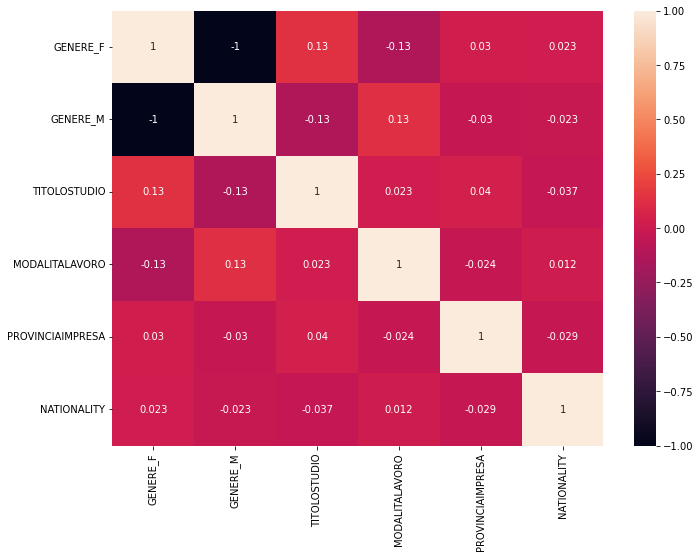

In [23]:
corrMatrix = activated_transformed.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

The correlation matrix does not show significative correlations between our features. Thus, performing the linear regression is not suitable in our case.

### XGBoost

Move target column to the last position

In [32]:
xgb_activated_transformed = activated_transformed.loc[:, activated_transformed.columns != 'TITOLOSTUDIO']
xgb_activated_transformed['TITOLOSTUDIO']= activated_transformed['TITOLOSTUDIO']

In [33]:
xgb_activated_transformed.head()

,GENERE_F,GENERE_M,MODALITALAVORO,PROVINCIAIMPRESA,NATIONALITY,TITOLOSTUDIO
0,1.0,0.0,2,7,89,0
1,1.0,0.0,2,7,89,0
2,1.0,0.0,2,0,89,0
3,0.0,1.0,4,7,89,0
4,0.0,1.0,4,7,89,0


In [37]:
#Prepare the dataset for prediction
X, y = xgb_activated_transformed.iloc[:,:-1], xgb_activated_transformed.iloc[:,-1]

In [39]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [43]:
xgbc = XGBClassifier()

In [46]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [48]:
#cross_val_score(xgbc, X_train, y_train, cv=5)

KeyboardInterrupt: 

In [ ]:
#kfold = KFold(n_splits=10, shuffle=True)
#cross_val_score(xgbc, X_train, y_train, cv=kfold )

In [50]:
ypred = xgbc.predict(X_test)

In [53]:
accuracy_score(y_test, ypred)

0.4128851400264828